# Imports

In [ ]:
from numpy import array, arange, zeros, transpose, cos, sin, atan2
from matplotlib import pyplot
from math import pi

# The System Models
## System Schematic

![Romi Robot](Diagram.jpeg)

The following differential equations represent the velocity dynamics of the two DC motors attached to Romi's wheels, as well as the dynamics of Romi's chassis. The inputs $u_L$ and $u_R$ are the left and right motor voltages which, through the motor dynamics, cause the velocities $\Omega_L$ and $\Omega_R$ to be produced. 

The preceding state equations can be combined into a single vector equation so that we can solve it using vector based ODE solution techniques.

$$
\begin{array}{rl}
\frac{d}{dt}
    \begin{bmatrix}
        \Omega_L \\[6pt]
        \Omega_R \\[6pt]
        X_R \\[6pt]
        Y_R \\[6pt]
        \psi_R \\[6pt]
        s \\[6pt]
        v \\[6pt]
        \Omega
    \end{bmatrix}
&=
\begin{bmatrix}
    \frac{k}{\tau} u_L - \frac{1}{\tau} \Omega_L \\[6pt]
    \frac{k}{\tau} u_R - \frac{1}{\tau} \Omega_R \\[6pt]
    \frac{r}{2}(\Omega_L + \Omega_R) \cdot \cos(\psi_R) \\[6pt]
    \frac{r}{2}(\Omega_L + \Omega_R) \cdot \sin(\psi_R) \\[6pt]
    \frac{r}{w}(\Omega_R - \Omega_L) \\[6pt]
    \frac{r}{2}(\Omega_R + \Omega_L) \\[6pt]
    \frac{rk}{\tau}\left(\frac{u_L + u_R}{2}\right) - \frac{1}{\tau}v \\[6pt]
    \frac{rk}{\tau}(u_R - u_L) - \frac{1}{\tau}\Omega
\end{bmatrix}
\end{array}
$$

The preceding sytem of equations are of the form $\dot{\mathbf{x}} = \mathbf{f}\left(t, \mathbf{x}\right)$ which is the standard form for nonlinear state-space systems. This system of equations represent the dynamics of the entire system; that is, all of the differential equations are wrapped up in one large matrix equation.

It is often the case that outputs of interest are not present in the state vector directly. In such instances a second set of equations is utilized to select outputs of interest in the form $\mathbf{y} = \mathbf{g}\left(t, \mathbf{x}\right)$. For the DC motor model, the desired outputs will include all state variables and also the coordinate of an arbitrary "point of interest" attached to Romi's chassis.
$$
\begin{array}{rl}
\begin{bmatrix}
    \Omega_L \\[6pt]
    \Omega_R \\[6pt]
    X_R \\[6pt]
    Y_R \\[6pt]
    \psi_R \\[6pt]
    X_{P1} \\[6pt]
    Y_{P1} \\[6pt]
    s \\[6pt]
    v \\[6pt]
    \Omega
\end{bmatrix}
&=
\begin{bmatrix}
    \Omega_L \\[6pt]
    \Omega_R \\[6pt]
    X_R \\[6pt]
    Y_R \\[6pt]
    \psi_R \\[6pt]
    X_R + X_P\cos\psi_R - Y_P\sin\psi_R \\[6pt]
    Y_R + X_P\sin\psi_R + Y_P\cos\psi_R \\[6pt]
    s \\[6pt]
    v \\[6pt]
    \Omega
\end{bmatrix}
\end{array}
$$

In the code below, there are two different functions defined; each one implements both the state equations, $\dot{\mathbf{x}} = \mathbf{f}\left(t, \mathbf{x}\right)$, and the output equations, $\mathbf{y} = \mathbf{g}\left(t, \mathbf{x}\right)$. The difference between the two functions is that the first implements an open-loop simulation and the second implements a closed loop simulation.

That is, the first function uses constant supply voltages of $u_L = 4.5\text{V}$ and $u_R=3\text{V}$ whereas the second function should use a feedback law that defines $u_L$ and $u_R$ in terms of state variables. This feedback law is still unimplemented and is up to the student.

## System Parameters
| Parameter | Symbol | Value | Unit | Description |
|-----------|--------|-------|------|-------------|
| Wheel radius | r | 0.035 | m | Radius of robot wheels |
| Track width | w | 0.15 | m | Distance between wheels |
| Point of interest x-offset | X_P | 0.05 | m | x-offset from center |
| Point of interest y-offset | Y_P | 0.05 | m | y-offset from center |
| Motor constant | k | 9.26 | rad/(V·s) | Motor speed constant (250·2π/60/4.5) |
| Time constant | τ | 0.1 | s | Motor time constant |

In [ ]:
# Romi parameters
r = 0.035        
w = 0.15          
X_P = 0.05        
Y_P = 0.05        

k = 9.26          
tau = 0.1

## Open Loop System Model
### Open Loop Block Diagram
![Open Loop Diagrap](Open.jpeg)

In [ ]:
def system_eqn_OL(t, x):
    '''!@brief      Implements both state equations and output equations for the
                    open loop system
        @param t    The value of time for a given simulation step
        @param x    The value of the state vector for a given simulation step
        @return     A tuple containing both the derivative of the state vector
                    and the output vector for a given simulation step
    '''
    # Extract state variables
    omega_L = x[0,0]
    omega_R = x[1,0]
    X_R = x[2,0]
    Y_R = x[3,0]
    psi_R = x[4,0]
    s = x[5,0]
    v = x[6,0]
    omega = x[7,0]

    # Constant motor voltages
    u_L = 4.5  
    u_R = 3.0  
    
    u = array([ [u_L],
                [u_R] ])
    
    # State equations 
    domega_L = (k/tau) * u[0,0] - (1/tau) * omega_L  
    domega_R = (k/tau) * u[1,0] - (1/tau) * omega_R  
    dX_R = (r/2) * (omega_R + omega_L) * cos(psi_R)  
    dY_R = (r/2) * (omega_R + omega_L) * sin(psi_R)  
    dpsi_R = (r/w) * (omega_R - omega_L) 
    ds = (r/2) * (omega_R + omega_L)  
    dv = (r*k/tau) * (u[0,0] + u[1,0])/2 - (1/tau) * v  
    domega = (r*k/(w*tau)) * (u[1,0] - u[0,0]) - (1/tau) * omega  

    xd = array([ [domega_L],
                 [domega_R],
                 [dX_R],
                 [dY_R],
                 [dpsi_R],
                 [ds],
                 [dv],
                 [domega]
                ])
    
    # Output Equations
    y = array([ [omega_L],
                [omega_R],
                [X_R],
                [Y_R],
                [psi_R],
                [X_R + X_P*cos(psi_R) - Y_P*sin(psi_R)],
                [Y_R + X_P*sin(psi_R) + Y_P*cos(psi_R)],
                [s],
                [v],
                [omega]
                ])
    
    return xd, y

## Closed Loop System Model
### Closed Loop Block Diagram
![Closed Loop Diagram](Closed.jpeg)


In [ ]:
def system_eqn_CL(t, x):
    '''!@brief      Implements both state equations and output equations for
                    the closed loop system
        @param t    The value of time for a given simulation step
        @param x    The value of the state vector for a given simulation step
        @return     A tuple containing both the derivative of the state vector
                    and the output vector for a given simulation step
    '''
    # Extract state variables
    omega_L = x[0,0]
    omega_R = x[1,0]
    X_R = x[2,0]
    Y_R = x[3,0]
    psi_R = x[4,0]
    s = x[5,0]
    v = x[6,0]
    omega = x[7,0]
    
    # Desired circle parameters
    radius = 0.5  
    v_des = 0.5  
    
    # Desired angular velocity 
    omega_des = v_des / radius
    
    # Calculate wheel velocities for circular motion
    omega_L_des = (v_des - (omega_des * w/2)) / r  
    omega_R_des = (v_des + (omega_des * w/2)) / r  
    # Omega error
    e_L = omega_L_des - omega_L
    e_R = omega_R_des - omega_R

    # Proportional gain
    kp = 1

    # Motor voltage inputs
    u_L = kp * e_L
    u_R = kp * e_R

    u = array([ [u_L],
                [u_R] ])
    
    # State equations
    domega_L = (k/tau) * u[0,0] - (1/tau) * omega_L  
    domega_R = (k/tau) * u[1,0] - (1/tau) * omega_R  
    dX_R = (r/2) * (omega_R + omega_L) * cos(psi_R)  
    dY_R = (r/2) * (omega_R + omega_L) * sin(psi_R)  
    dpsi_R = (r/w) * (omega_R - omega_L) 
    ds = (r/2) * (omega_R + omega_L)  
    dv = (r*k/tau) * (u[0,0] + u[1,0])/2 - (1/tau) * v  
    domega = (r*k/(w*tau)) * (u[1,0] - u[0,0]) - (1/tau) * omega  
    
    xd = array([ [domega_L],
                 [domega_R],
                 [dX_R],
                 [dY_R],
                 [dpsi_R],
                 [ds],
                 [dv],
                 [domega]
                ])
    
    # Output Equations
    y = array([ [omega_L],
                [omega_R],
                [X_R],
                [Y_R],
                [psi_R],
                [X_R + X_P*cos(psi_R) - Y_P*sin(psi_R)],
                [Y_R + X_P*sin(psi_R) + Y_P*cos(psi_R)],
                [s],
                [v],
                [omega]
                ])
    
    return xd, y
  

## Solver
### Runge-Kutta Method (4th-order)
The following algorithm is presented without derivation, but is a marked improvement over Euler's method presented above. The integration technique is fourth-order, instead first-order, so has a much smaller truncation error for a given step size. Using an "RK" solver will allow you to use a much more reasonable step size and still get a solution of reasonable accuracy. The algorithm is similar to Euler's method, however it splits the window of time, $\Delta t$, in half and computes the derivative several times at the start of the time window, in the middle, and at the end. These derivatives are used to find a weighted average which is then used in a standard Euler step.
$$
\begin{array}{rl}
\mathbf{x}_{n+1} &= \mathbf{x}_{n} + \frac{1}{6} \left(\mathbf{k}_1 + 2 \mathbf{k}_2 + 2 \mathbf{k}_3 + \mathbf{k}_4 \right) \Delta t
\end{array}
$$
where,
$$
\begin{array}{rll}
\mathbf{k}_1 &= \mathbf{f}(t, & \mathbf{x}_n)                                              \\[4pt]
\mathbf{k}_2 &= \mathbf{f}(t+\frac{1}{2}\Delta t, & \mathbf{x}_n+\frac{1}{2} k_1 \Delta t) \\[4pt]
\mathbf{k}_3 &= \mathbf{f}(t+\frac{1}{2}\Delta t, & \mathbf{x}_n+\frac{1}{2} k_2 \Delta t) \\[4pt]
\mathbf{k}_4 &= \mathbf{f}(t+\Delta t, & \mathbf{x}_n+k_3 \Delta t)
\end{array}
$$


In [ ]:
def RK4_solver(fcn, x_0, tspan, tstep):
    '''!@brief        Implements a fourth-order Runge-Kutta solver
        @param fcn    A function handle to the function to solve
        @param x_0    The initial value of the state vector
        @param tspan  A span of time over which to solve the system specified
                      as a list with two elements representing initial and
                      final time values
        @param tstep  The step size to use for the integration algorithm
        @return       A tuple containing both an array of time values and an
                      array of output values
    '''

    tout = arange(tspan[0], tspan[1]+tstep, tstep)
    
    # Initialize state and output arrays
    n = len(x_0)
    xout = zeros([len(tout), n])
    
    # Set initial state
    xout[0] = x_0.flatten()
    
    # Get output dimension 
    initial_xd, initial_y = fcn(tout[0], xout[0].reshape(-1, 1))
    r = len(initial_y)
    yout = zeros([len(tout), r])
    
    # Store initial output
    yout[0] = initial_y.flatten()

    # Run integration loop
    for i in range(len(tout)-1):
        t = tout[i]
        x = xout[i].reshape(-1, 1)  
        
        # RK4 intermediate steps
        k1, _ = fcn(t, x)
        k2, _ = fcn(t + tstep/2, x + (tstep/2) * k1)
        k3, _ = fcn(t + tstep/2, x + (tstep/2) * k2)
        k4, _ = fcn(t + tstep, x + tstep * k3)
        
        # Update state next step
        xout[i+1] = xout[i] + (tstep/6) * (k1.flatten() + 2*k2.flatten() + 2*k3.flatten() + k4.flatten())
        
        # Get output for next step
        _, y = fcn(tout[i+1], xout[i+1].reshape(-1, 1))
        yout[i+1] = y.flatten()

    return tout, yout

## Running the Open-Loop Simulation

In [ ]:
# Initial conditions
x_0 = array([ [0],     
              [0],      
              [0],     
              [0],      
              [0],      
              [0],     
              [0],      
              [0]       
             ])

t_OL, y_OL = RK4_solver(system_eqn_OL, x_0, [0, 10], 1e-3)

### Plotting the Open-Loop Simulation

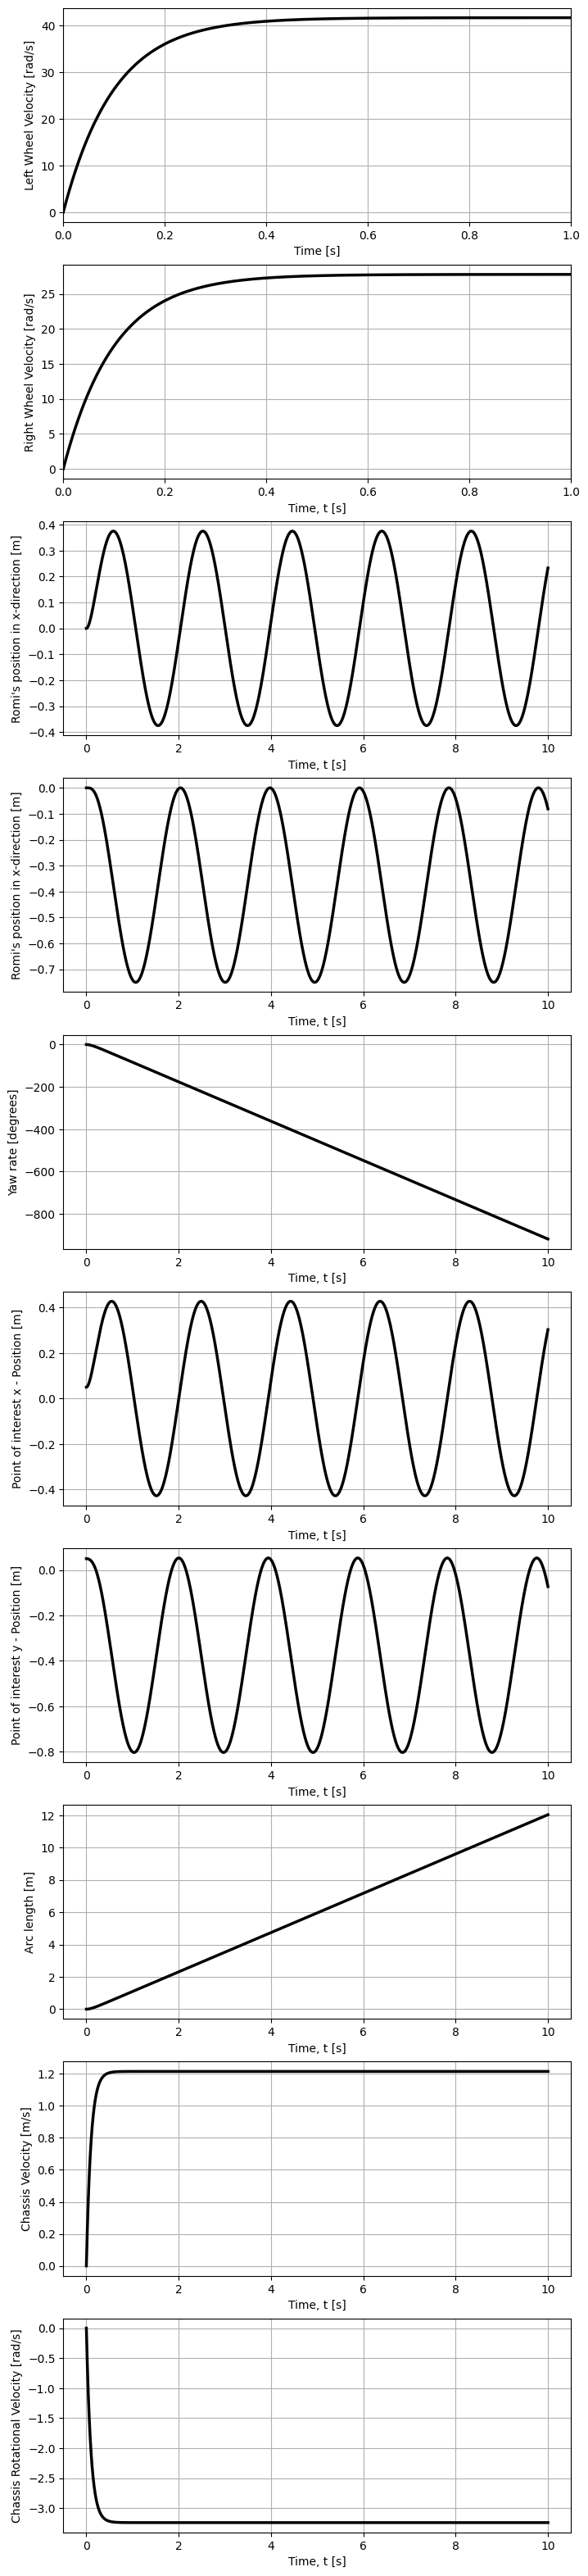

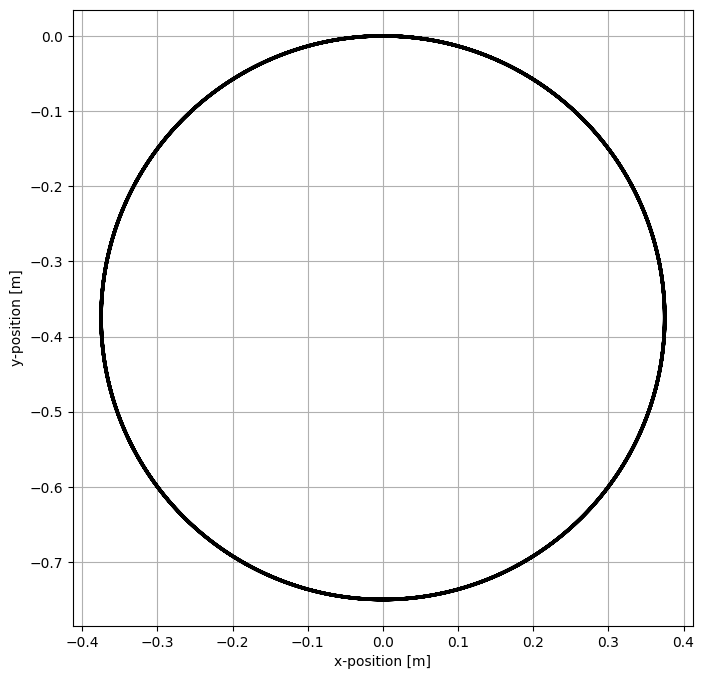

In [ ]:
pyplot.figure(figsize=(8, 40))

pyplot.subplot(10, 1, 1)
pyplot.plot(t_OL, y_OL[:, 0],
            linewidth=2.5,
            color=(0, 0, 0))
pyplot.xlim(0, 1)  
pyplot.xlabel('Time [s]')
pyplot.ylabel('Left Wheel Velocity [rad/s]')
pyplot.grid()

pyplot.subplot(10, 1, 2)
pyplot.plot(t_OL, y_OL[:, 1],
            linewidth=2.5,
            color=(0, 0, 0))
pyplot.xlim(0, 1)  
pyplot.xlabel('Time, t [s]')
pyplot.ylabel('Right Wheel Velocity [rad/s]')
pyplot.grid()

pyplot.subplot(10, 1, 3)
pyplot.plot(t_OL, y_OL[:, 2],
            linewidth=2.5,
            color=(0, 0, 0))
pyplot.xlabel('Time, t [s]')
pyplot.ylabel("Romi's position in x-direction [m]")
pyplot.grid()

pyplot.subplot(10, 1, 4)
pyplot.plot(t_OL, y_OL[:, 3],
            linewidth=2.5,
            color=(0, 0, 0))
pyplot.xlabel('Time, t [s]')
pyplot.ylabel("Romi's position in x-direction [m]")
pyplot.grid()

pyplot.subplot(10, 1, 5)
pyplot.plot(t_OL, y_OL[:, 4] * 180 / (2 * pi),
            linewidth=2.5,
            color=(0, 0, 0))
pyplot.xlabel('Time, t [s]')
pyplot.ylabel("Yaw rate [degrees]")
pyplot.grid()

pyplot.subplot(10, 1, 6)
pyplot.plot(t_OL, y_OL[:, 5],
            linewidth=2.5,
            color=(0, 0, 0))
pyplot.xlabel('Time, t [s]')
pyplot.ylabel("Point of interest x - Position [m]")
pyplot.grid()

pyplot.subplot(10, 1, 7)
pyplot.plot(t_OL, y_OL[:, 6],
            linewidth=2.5,
            color=(0, 0, 0))
pyplot.xlabel('Time, t [s]')
pyplot.ylabel("Point of interest y - Position [m]")
pyplot.grid()

pyplot.subplot(10, 1, 8)
pyplot.plot(t_OL, y_OL[:, 7],
            linewidth=2.5,
            color=(0, 0, 0))
pyplot.xlabel('Time, t [s]')
pyplot.ylabel("Arc length [m]")
pyplot.grid()

pyplot.subplot(10, 1, 9)
pyplot.plot(t_OL, y_OL[:, 8],
            linewidth=2.5,
            color=(0, 0, 0))
pyplot.xlabel('Time, t [s]')
pyplot.ylabel("Chassis Velocity [m/s]")
pyplot.grid()

pyplot.subplot(10, 1, 10)
pyplot.plot(t_OL, y_OL[:, 9],
            linewidth=2.5,
            color=(0, 0, 0))
pyplot.xlabel('Time, t [s]')
pyplot.ylabel("Chassis Rotational Velocity [rad/s]")
pyplot.grid()

pyplot.figure(figsize=(8, 8))
pyplot.plot(y_OL[:, 2], y_OL[:, 3],
            linewidth=2.5,
            color=(0, 0, 0))
pyplot.xlabel("x-position [m]")
pyplot.ylabel("y-position [m]")
pyplot.axis('equal')
pyplot.grid()

## Running the Closed-Loop Simulation

In [256]:
t_CL, y_CL = RK4_solver(system_eqn_CL, x_0, [0, 10], 1e-3)

### Plotting the Closed-Loop Simulation

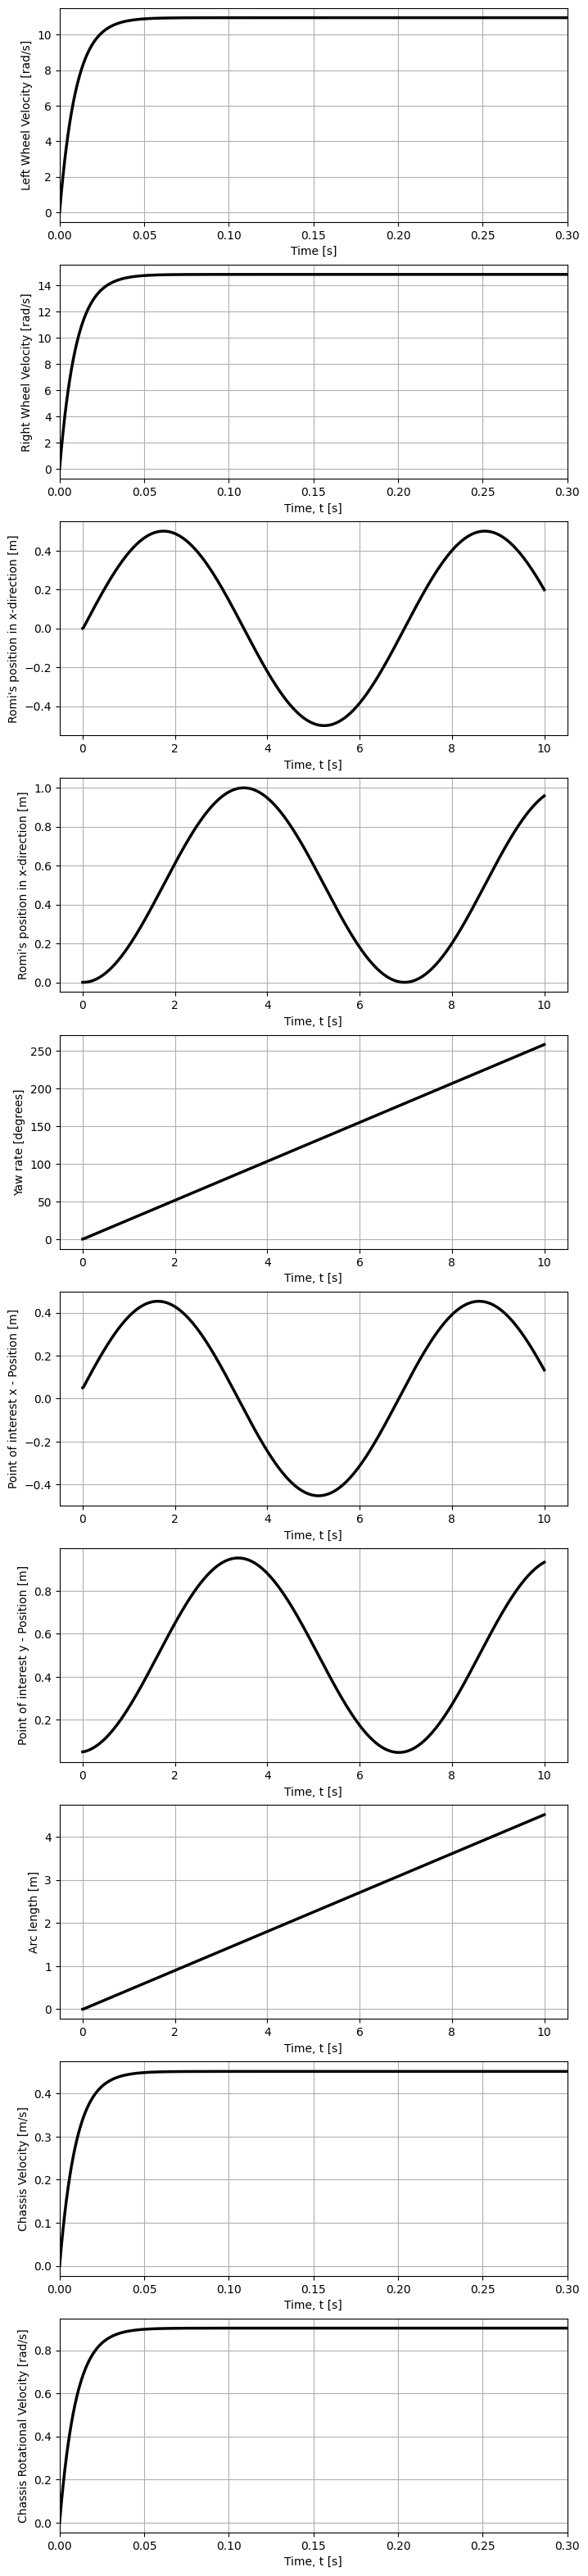

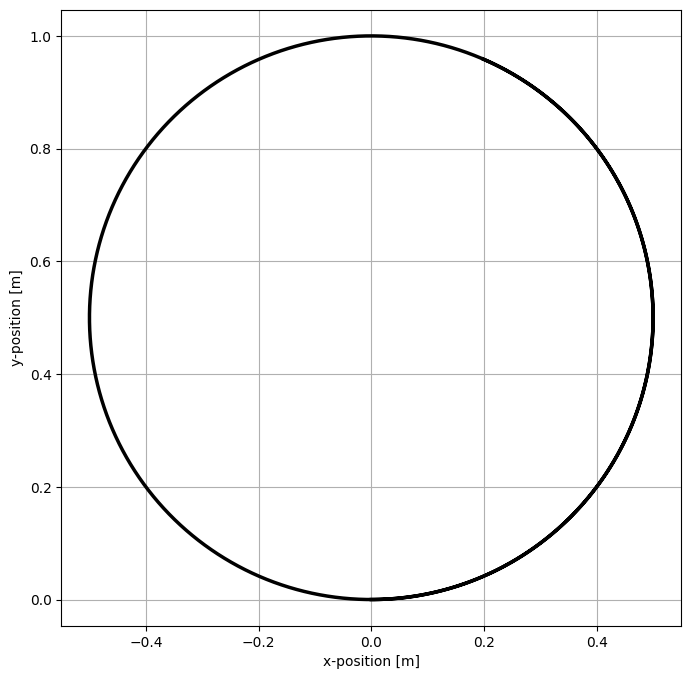

In [ ]:
pyplot.figure(figsize=(8,40))

pyplot.subplot(10,1,1)
pyplot.plot(t_CL, y_CL[:,0],
            linewidth=2.5,
            color=(0,0,0))
pyplot.xlim(0, 0.3)  
pyplot.xlabel('Time [s]')
pyplot.ylabel('Left Wheel Velocity [rad/s]')
pyplot.grid()

pyplot.subplot(10,1,2)
pyplot.plot(t_CL, y_CL[:,1],
            linewidth=2.5,
            color=(0,0,0))
pyplot.xlim(0, 0.3)  
pyplot.xlabel('Time, t [s]')
pyplot.ylabel('Right Wheel Velocity [rad/s]')
pyplot.grid()

pyplot.subplot(10,1,3)
pyplot.plot(t_CL, y_CL[:,2],
            linewidth=2.5,
            color=(0,0,0))
pyplot.xlabel('Time, t [s]')
pyplot.ylabel("Romi's position in x-direction [m]")
pyplot.grid()

pyplot.subplot(10,1,4)
pyplot.plot(t_CL, y_CL[:,3],
            linewidth=2.5,
            color=(0,0,0))
pyplot.xlabel('Time, t [s]')
pyplot.ylabel("Romi's position in x-direction [m]")
pyplot.grid()

pyplot.subplot(10,1,5)
pyplot.plot(t_CL, y_CL[:,4]*180/(2*pi),
            linewidth=2.5,
            color=(0,0,0))
pyplot.xlabel('Time, t [s]')
pyplot.ylabel("Yaw rate [degrees]")
pyplot.grid()

pyplot.subplot(10,1,6)
pyplot.plot(t_CL, y_CL[:,5],
            linewidth=2.5,
            color=(0,0,0))
pyplot.xlabel('Time, t [s]')
pyplot.ylabel("Point of interest x - Position [m]")
pyplot.grid()

pyplot.subplot(10,1,7)
pyplot.plot(t_CL, y_CL[:,6],
            linewidth=2.5,
            color=(0,0,0))
pyplot.xlabel('Time, t [s]')
pyplot.ylabel("Point of interest y - Position [m]")
pyplot.grid()

pyplot.subplot(10,1,8)
pyplot.plot(t_CL, y_CL[:,7],
            linewidth=2.5,
            color=(0,0,0))
pyplot.xlabel('Time, t [s]')
pyplot.ylabel("Arc length [m]")
pyplot.grid()

pyplot.subplot(10,1,9)
pyplot.plot(t_CL, y_CL[:,8],
            linewidth=2.5,
            color=(0,0,0))
pyplot.xlim(0, 0.3)  
pyplot.xlabel('Time, t [s]')
pyplot.ylabel("Chassis Velocity [m/s]")
pyplot.grid()

pyplot.subplot(10,1,10)
pyplot.plot(t_CL, y_CL[:,9],
            linewidth=2.5,
            color=(0,0,0))
pyplot.xlim(0, 0.3)  
pyplot.xlabel('Time, t [s]')
pyplot.ylabel("Chassis Rotational Velocity [rad/s]")
pyplot.grid()

pyplot.figure(figsize=(8, 8))
pyplot.plot(y_CL[:,2], y_CL[:,3],
            linewidth=2.5,
            color=(0,0,0))
pyplot.xlabel("x-position [m]")
pyplot.ylabel("y-position [m]")
pyplot.axis('equal')
pyplot.grid()

## Discussion Questions
1. Explore the validity of the no-slip assumption and any other assumptions required for the kinematic model in favor of a full dynamic model. Consider things like how the nonlinear aspect of the motors may or may not easily integrate with the model, how the mass and friction properties of the system may influence the model, and any other effects that may not match the idealized nature of the kinematic model. Is the kinematic model good enough for our purposes?

In this simulation, the no-slip assumption is valid because the motors are being run at a low enough speed to elimate any slippage in the wheels. In a kinematic model, the mass and friction properties are not considered, but they could have a big affect on the time for the motors to reach steady-state and create deviations with the desired motion for Romi, but for our purpose of simulating the dynamics of Romi, this kinematic model is good enough to get an accurate response.

2. In Lab 0x02 or 0x03 you ran step response tests to experimentally determine the open loop time constant of Romi while driving forward. Is it valid to assume that the time constant while driving forward is the same time constant while turning? Compare pivoting in place and driving in a straight line, will both of these cases have the same effective inertia loading the motors?

The open loop time constant is a measure of how fast it takes Romi to reach steady-state while driving in a straight line. While turning, one motor has to reach a higher velocity than the other, so one will have a higher time constant than the other resulting in a higher overall time constant while turning compared to driving in a straight line.

3. One of the problems with models like this is that significant deviation or drift will occur between the simulation and the behavior of the real vehicle, especially when accumulated over a long simulation. The concept of dead reckoning is that we can predict the position of a system simply by integrating its velocity or acceleration over time. Naturally, small devi-
ations, like those caused by minor wheel slip, add up over time. A small error in velocity, once integrated over time to produce position, can lead to wildly inaccurate estimations of position. 
How can we correct for this drift error? What other information would help us keep our simulated model tracking with reality? Hint: consider what kind of sensors may be added to the robot to measure the value of your selected state variables.

To account for drift error, which comes from deviations in velocity estimations, we can use encoders to measure the actual velocity of the motors and feed it back to the motor controller to eliminate any error, and we can also use the IMU sensor in tandem to track the actual yaw rate and calculate Romi's position over time.

4. While this is not a controls course, you will need to implement some kind of controller on your robot to complete the term project. For this question, investigate ways in which you may incorporate feedback into your system to make the robot move in ways that will be advantageous for the term project. Address nuances such as:

• What sensor inputs will be useful for feedback.

• How you might split up a complicated path into segments such as straight lines, circular arcs, in-place turns, etc.

The main sensor inputs that will be useful for controller feedback are the motors angular velocity from encoder measurements, the chassis's yaw rate from the IMU sensor, and the reflectance sensors to track position along the black line. The combination of these readings will allow us to implement a controller that keeps Romi centered along the black line of the track and maintain our desired velocity.

5. Is it possible to determine the orientation and location of the robot after it has followed a specific path simply by knowing the angle swept out by each wheel? If not, would it be possible to know the orientation and location with a time-history of the angle swept out by each wheel? If you know the robot’s orientation and location, can you figure out the angle swept out by each wheel?
Investigate what information is required to track the robots absolute position in space, or possibly its position relative to a particular maneuver, like a circular arc. What kind of data will you need to track in your firmware to make use of this information?

Yes, it is possible to determine the orientation and location of Romi by knowing the angle swept out by each wheel because we know the starting position and orientation and can calculate the rotation and distance traveled through the kinematic model. Our wheel encoders, IMU sensor, mainly the gyroscope, and kinematic model gives us the information needed to track Romi's absolute position and oriantation, as well as the position relative to a particular maneuver.